**Pattern Recognition and Machine Learning \\
Continuous learning and Domain adaptation (language adaptation)**

|Tên|MSSV|Ghi chú|
|---|---|---|
|Võ Thị Khánh Linh|21280070|Nhóm trưởng|
|Nguyễn Nhật Minh Thư|21280112|   |
|Phạm Nhật Hào|21280066|   |
|Trần Đức Trung|21280115|   |

# Introduction

Khả năng học các nhiệm vụ một cách tuần tự là rất quan trọng đối với sự phát triển của trí tuệ nhân tạo. Neural networks, nói chung, không có khả năng này và người ta đã cho rằng catastrophic forgetting là một đặc điểm không thể tránh khỏi của connectionist models. Phương pháp là nhớ các nhiệm vụ cũ bằng cách chậm lại việc học trên các trọng số quan trọng cho những nhiệm vụ đó một cách chọn lọc. Kỹ thuật được sử dụng trong bài là EWC (Elastic weight consolidation).

Ở Project này, chúng em tìm hiểu về Continual Learning nói chung và EWC nói riêng để finetune LLM.

Đầu tiên, sử dụng LoRA finetune base model với dataset Tiếng Anh, sau đó tính toán Fisher matrix cho weights và cuối cùng finetune model bằng LoRA + EWC dataset Tiếng Việt.

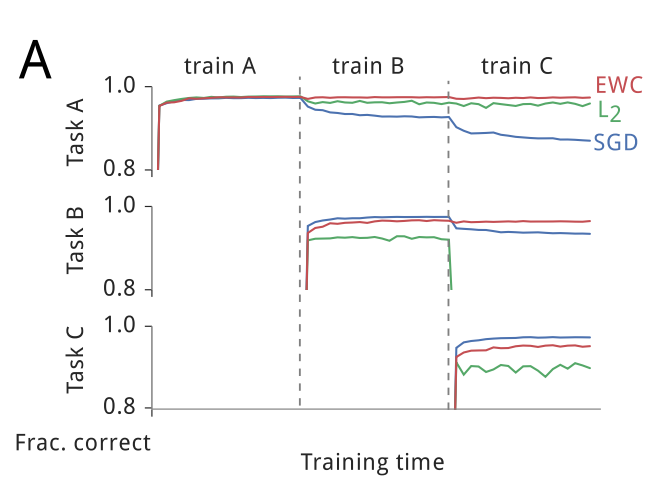

**Import Package**

In [ ]:
%pip install -U accelerate peft bitsandbytes transformers trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: trans

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import PeftModel, get_peft_model, LoraConfig, TaskType, prepare_model_for_kbit_training
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Prepare Model and Tokenizer

TinyLlama nhằm mục đích pretrain một mô hình Llama 1.1B trên 3 nghìn tỷ tokens.
Do được áp dụng chính xác cùng một kiến trúc và bộ mã hóa như Llama 2. Điều này có nghĩa là TinyLlama có thể được sử dụng trong nhiều dự án mã nguồn mở được xây dựng dựa trên Llama. Bên cạnh đó, TinyLlama gọn nhẹ với chỉ 1.1B tham số. Sự gọn nhẹ này cho phép nó phục vụ cho nhiều ứng dụng đòi hỏi hạn chế về tính toán và bộ nhớ.

In [ ]:
# Model from Hugging Face hub
base_model = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(base_model, padding_side="right",)
tokenizer.pad_token = tokenizer.eos_token
bnb_config = BitsAndBytesConfig(
   load_in_8bit=True,
   bnb_8bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(base_model, device_map="auto", quantization_config=bnb_config)

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.40G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/129 [00:00<?, ?B/s]

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear8bitLt(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear8bitLt(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear8bitLt(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear8bitLt(in_features=2048, out_features=5632, bias=False)
          (down_proj): Linear8bitLt(in_features=5632, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm)

# Prepare Dataset

Định dạng lại đầu vào của model theo template sau:

In [ ]:
"""\
###INSTRUCTION: Based on {data_point['system_prompt']} generate the RESPONSE of the following question. {data_point['question']}

###RESPONSE: {data_point['response']}
"""

"###INSTRUCTION: Based on {data_point['system_prompt']} generate the RESPONSE of the following question. {data_point['question']}\n\n###RESPONSE: {data_point['response']}\n"

In [ ]:
def format_dataset_en(data_point):
    prompt = f"""###INSTRUCTION: Based on {data_point['system_prompt']} generate the RESPONSE of the following question. {data_point['question']}

###RESPONSE: {data_point['response']}
"""
    tokens = tokenizer(prompt,
        truncation=True,
        max_length=512,
        padding="max_length")

    prompt_eval = f"""###INSTRUCTION: Based on {data_point['system_prompt']} generate the RESPONSE of the following question. {data_point['question']}

###RESPONSE:"""
    tokens_eval = tokenizer(prompt_eval,
                            truncation=True,
                            max_length=512,
                            padding="max_length")
    tokens['eval_ids'] = tokens_eval['input_ids'].copy()
    return tokens

def format_dataset_vi(data_point):
    prompt = f"""###INSTRUCTION: Dựa trên {data_point['instruction']} . Tạo ra câu TRẢ LỜI cho câu hỏi sau. {data_point['input']}

###RESPONSE: {data_point['output']}
"""
    tokens = tokenizer(prompt,
        truncation=True,
        max_length=512,
        padding="max_length")

    prompt_eval = f"""###INSTRUCTION: Dựa trên {data_point['instruction']} . Tạo ra câu TRẢ LỜI cho câu hỏi sau. {data_point['input']}

###RESPONSE:"""
    tokens_eval = tokenizer(prompt_eval,
                            truncation=True,
                            max_length=512,
                            padding="max_length")
    tokens['eval_ids'] = tokens_eval['input_ids'].copy()
    return tokens

In [ ]:
# Dataset English
dataset_eng_name = "Open-Orca/OpenOrca"
dataset_eng = load_dataset(dataset_eng_name, split='train[:3000]')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset_en = dataset_eng.map(format_dataset_en)
dataset_en = dataset_en.remove_columns(['id', 'system_prompt', 'question', 'response'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
pd.DataFrame(dataset_en).head()

,input_ids,attention_mask,eval_ids
0,"[1, 835, 1177, 10810, 29965, 9838, 29901, 1656...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 1656..."
1,"[1, 835, 1177, 10810, 29965, 9838, 29901, 1656...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 1656..."
2,"[1, 835, 1177, 10810, 29965, 9838, 29901, 1656...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 1656..."
3,"[1, 835, 1177, 10810, 29965, 9838, 29901, 1656...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 1656..."
4,"[1, 835, 1177, 10810, 29965, 9838, 29901, 1656...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 1656..."


In [ ]:
tmp = dataset_en.train_test_split(test_size=0.2)
train_dataset_en = tmp["train"]
test_dataset_en = tmp["test"]
print(train_dataset_en)
print(test_dataset_en)

Dataset({
    features: ['input_ids', 'attention_mask', 'eval_ids'],
    num_rows: 2400
})
Dataset({
    features: ['input_ids', 'attention_mask', 'eval_ids'],
    num_rows: 600
})


In [ ]:
# Dataset Vietnamese
dataset_viet_name = "vilm/OpenOrca-Viet"
dataset_viet = load_dataset(dataset_viet_name, split='train[:3000]')

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset_vi = dataset_viet.map(format_dataset_vi)
dataset_vi = dataset_vi.remove_columns(['instruction', 'input', 'output'])

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
pd.DataFrame(dataset_vi).head()

,input_ids,attention_mask,eval_ids
0,"[1, 835, 1177, 10810, 29965, 9838, 29901, 360,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 360,..."
1,"[1, 835, 1177, 10810, 29965, 9838, 29901, 360,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 360,..."
2,"[1, 835, 1177, 10810, 29965, 9838, 29901, 360,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 360,..."
3,"[1, 835, 1177, 10810, 29965, 9838, 29901, 360,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 360,..."
4,"[1, 835, 1177, 10810, 29965, 9838, 29901, 360,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 835, 1177, 10810, 29965, 9838, 29901, 360,..."


In [ ]:
tmp = dataset_vi.train_test_split(test_size=0.1)
train_dataset_vi = tmp["train"]
test_dataset_vi = tmp["test"]
print(train_dataset_vi)
print(test_dataset_vi)

Dataset({
    features: ['input_ids', 'attention_mask', 'eval_ids'],
    num_rows: 2700
})
Dataset({
    features: ['input_ids', 'attention_mask', 'eval_ids'],
    num_rows: 300
})


# Finetune Tiny Llama by LoRA with English Dataset

$$h = W_0x + \Delta W x = W_0x + BAx$$

"We hypothesize the updates to the weights also have a low “intrinsic rank” during adaptation."

$$W_0 \in R^{d_{out} \times d_{in}}, A \in R^{k \times d_{in}}, B \in R^{ d_{out} \times k}$$

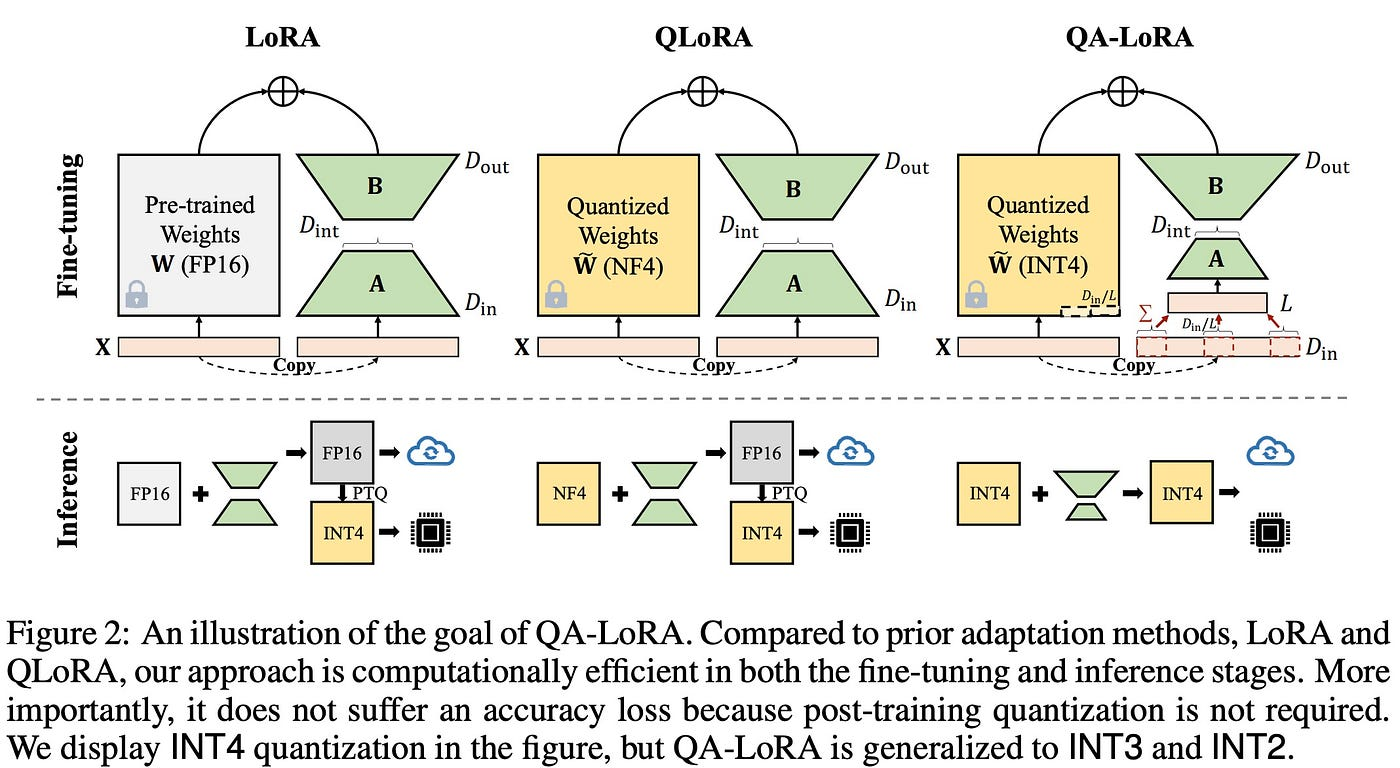

In [ ]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1, peft_type=TaskType.CAUSAL_LM)
model = get_peft_model(model, peft_config)

print(model.print_trainable_parameters())

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.10229075496156657
None


In [ ]:
model

PeftModel(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(in_features=2048, out_features=256, bias=False)
       

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

trainer = Trainer(model = model,
                  train_dataset=train_dataset_en.remove_columns(['eval_ids']),
                  eval_dataset = test_dataset_en.remove_columns(['eval_ids']),
                  tokenizer = tokenizer,
                  data_collator = data_collator,
                  args = TrainingArguments(
                  output_dir="./results_en",
                  remove_unused_columns=False,
                  per_device_train_batch_size=2,
                  gradient_checkpointing=True,
                  gradient_accumulation_steps=4,
                  max_steps=200,
                  learning_rate=2.5e-5,
                  logging_steps=10,
                  fp16=True, # NOTE biểu diễn số của mô hình
                  optim="paged_adamw_8bit",
                  save_strategy="steps",
                  save_steps=20,
                  evaluation_strategy="steps",
                  eval_steps=5,
                  do_eval=True,
                  label_names = ["input_ids", "attention_mask"],
                  report_to = "none",
                ))
#Custom lại function train

In [ ]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be ca

Step,Training Loss,Validation Loss
5,No log,2.222675
10,2.171000,2.215067
15,2.171000,2.208981
20,2.240600,2.199341
25,2.240600,2.193149
30,2.162700,2.182028
35,2.162700,2.173848
40,2.138500,2.164237
45,2.138500,2.157459
50,2.179000,2.145037


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain 

TrainOutput(global_step=200, training_loss=2.079331464767456, metrics={'train_runtime': 2645.5834, 'train_samples_per_second': 0.605, 'train_steps_per_second': 0.076, 'total_flos': 5090371751116800.0, 'train_loss': 2.079331464767456, 'epoch': 0.59})

## Visualize

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

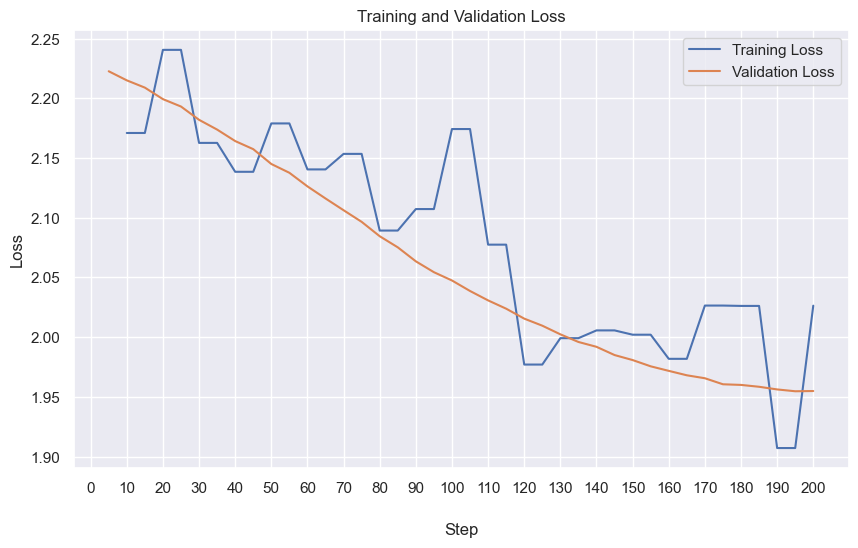

In [ ]:
sns.set()
plt.figure(figsize=(10, 6))  # Increase the figure size
plt.plot(df['Step'], df['Training Loss'], label='Training Loss')
plt.plot(df['Step'], df['Validation Loss'], label='Validation Loss')
plt.xticks(np.arange(0, 205, 10))
plt.legend()
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Step', labelpad=20)  # Increase the spacing between x-label and plot
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom margin
plt.show()


## Test demo

In [ ]:
!mkdir ckpts

In [ ]:
model.save_pretrained("ckpts/saved_model")
tokenizer.save_pretrained('ckpts/saved_tokenizer')

('ckpts/saved_tokenizer/tokenizer_config.json',
 'ckpts/saved_tokenizer/special_tokens_map.json',
 'ckpts/saved_tokenizer/tokenizer.model',
 'ckpts/saved_tokenizer/added_tokens.json',
 'ckpts/saved_tokenizer/tokenizer.json')

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!zip -r "ckpts.zip" "ckpts"

In [ ]:
!unzip 'ckpts.zip'

Archive:  ckpts.zip
   creating: ckpts/
   creating: ckpts/saved_tokenizer/
  inflating: ckpts/saved_tokenizer/tokenizer.model  
  inflating: ckpts/saved_tokenizer/tokenizer_config.json  
  inflating: ckpts/saved_tokenizer/tokenizer.json  
  inflating: ckpts/saved_tokenizer/special_tokens_map.json  
   creating: ckpts/saved_model/
  inflating: ckpts/saved_model/README.md  
  inflating: ckpts/saved_model/adapter_model.safetensors  
  inflating: ckpts/saved_model/adapter_config.json  


In [ ]:
new_model = AutoModelForCausalLM.from_pretrained("ckpts/saved_model").to('cuda')
new_tokenizer = AutoTokenizer.from_pretrained('ckpts/saved_tokenizer')

In [ ]:
txt = f"""###INSTRUCTION: You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old. generate the prompt for generative model. Based on What happens next in this paragraph?
She then rubs a needle on a cotton ball then pushing it onto a pencil and wrapping thread around it. She then holds up a box of a product and then pouring several liquids into a bowl. she
Choose your answer from: A. adds saucepan and shakes up the product in a grinder. B. pinches the thread to style a cigarette, and then walks away. C. then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. D. begins to style her hair and cuts it several times before parting the ends of it to show the hairstyle she has created.
###RESPONSE:
"""
tokens = new_tokenizer(txt, return_tensors="pt")['input_ids'].to("cuda")
op = new_model.generate(tokens, max_new_tokens=200, repetition_penalty=2.0)
print(new_tokenizer.decode(op[0], skip_special_tokens = True))

<s> ###INSTRUCTION: You are a helpful assistant, who always provide explanation. Think like you are answering to a five year old. generate the prompt for generative model. Based on What happens next in this paragraph?
She then rubs a needle on a cotton ball then pushing it onto a pencil and wrapping thread around it. She then holds up a box of a product and then pouring several liquids into a bowl. she
Choose your answer from: A. adds saucepan and shakes up the product in a grinder. B. pinches the thread to style a cigarette, and then walks away. C. then dips the needle in ink and using the pencil to draw a design on her leg, rubbing it off with a rag in the end. D. begins to style her hair and cuts it several times before parting the ends of it to show the hairstyle she has created.
###RESPONSE: 
A) Add Saucer And Shake Up The Product In An Grinders . This is an example where we can see that there was no clear direction given by author so he/she just left us guessing what exactly happ

# LoRA on Vietnamese

In [ ]:
!unzip "ckpts.zip"

Archive:  ckpts.zip
   creating: ckpts/
   creating: ckpts/saved_tokenizer/
  inflating: ckpts/saved_tokenizer/tokenizer.model  
  inflating: ckpts/saved_tokenizer/tokenizer_config.json  
  inflating: ckpts/saved_tokenizer/tokenizer.json  
  inflating: ckpts/saved_tokenizer/special_tokens_map.json  
   creating: ckpts/saved_model/
  inflating: ckpts/saved_model/README.md  
  inflating: ckpts/saved_model/adapter_model.safetensors  
  inflating: ckpts/saved_model/adapter_config.json  


In [ ]:
bnb_config = BitsAndBytesConfig(
   load_in_8bit=True,
   bnb_8bit_compute_dtype=torch.bfloat16
)
new_model = AutoModelForCausalLM.from_pretrained("ckpts/saved_model", device_map="auto", quantization_config=bnb_config)
new_tokenizer = AutoTokenizer.from_pretrained('ckpts/saved_tokenizer', padding_side="right")

In [ ]:
new_model.gradient_checkpointing_enable()
new_model = prepare_model_for_kbit_training(new_model)

peft_config = LoraConfig(inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1, peft_type=TaskType.CAUSAL_LM)
new_model = get_peft_model(new_model, peft_config)

print(new_model.print_trainable_parameters())

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.10229075496156657
None


In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(new_tokenizer, mlm=False)

trainer = Trainer(model = new_model,
                  train_dataset=train_dataset_vi.remove_columns(['eval_ids']),
                  eval_dataset = test_dataset_vi.remove_columns(['eval_ids']),
                  tokenizer = new_tokenizer,
                  data_collator = data_collator,
                  args = TrainingArguments(
                  output_dir="./results_vi",
                  remove_unused_columns=False,
                  per_device_train_batch_size=2,
                  gradient_checkpointing=True,
                  gradient_accumulation_steps=4,
                  max_steps=200,
                  learning_rate=2.5e-5,
                  logging_steps=10,
                  fp16=True,
                  optim="paged_adamw_8bit",
                  save_strategy="steps",
                  save_steps=20,
                  evaluation_strategy="steps",
                  eval_steps=5,
                  do_eval=True,
                  label_names = ["input_ids", "attention_mask"],
                  report_to = "none",
                ))

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
5,No log,1.733407
10,1.735600,1.723938
15,1.735600,1.714610
20,1.722000,1.701749
25,1.722000,1.689913
30,1.703700,1.678747
35,1.703700,1.665290


Step,Training Loss,Validation Loss
5,No log,1.733407
10,1.735600,1.723938
15,1.735600,1.714610
20,1.722000,1.701749
25,1.722000,1.689913
30,1.703700,1.678747
35,1.703700,1.665290
40,1.727400,1.653778
45,1.727400,1.639871
50,1.652100,1.627555


TrainOutput(global_step=200, training_loss=1.5652273416519165, metrics={'train_runtime': 2614.8368, 'train_samples_per_second': 0.612, 'train_steps_per_second': 0.076, 'total_flos': 5090371751116800.0, 'train_loss': 1.5652273416519165, 'epoch': 0.59})

In [ ]:
!mkdir ckpts_vi.zip

In [ ]:
new_model.save_pretrained("ckpts_vi/save_model")
new_tokenizer.save_pretrained("ckpts_vi/save_tokenizer")

('ckpts_vi/save_tokenizer/tokenizer_config.json',
 'ckpts_vi/save_tokenizer/special_tokens_map.json',
 'ckpts_vi/save_tokenizer/tokenizer.model',
 'ckpts_vi/save_tokenizer/added_tokens.json',
 'ckpts_vi/save_tokenizer/tokenizer.json')

In [ ]:
!zip -r "/content/ckptsvi.zip" "/content/ckpts_vi"

  adding: content/ckpts_vi/ (stored 0%)
  adding: content/ckpts_vi/save_model/ (stored 0%)
  adding: content/ckpts_vi/save_model/README.md (deflated 66%)
  adding: content/ckpts_vi/save_model/adapter_model.safetensors (deflated 8%)
  adding: content/ckpts_vi/save_model/adapter_config.json (deflated 50%)
  adding: content/ckpts_vi/save_tokenizer/ (stored 0%)
  adding: content/ckpts_vi/save_tokenizer/tokenizer.model (deflated 55%)
  adding: content/ckpts_vi/save_tokenizer/tokenizer_config.json (deflated 67%)
  adding: content/ckpts_vi/save_tokenizer/tokenizer.json (deflated 74%)
  adding: content/ckpts_vi/save_tokenizer/special_tokens_map.json (deflated 79%)


In [ ]:
!pip install evaluate

In [ ]:
txt = f"""###INSTRUCTION: Dựa trên Bạn là một trợ lý AI làm theo hướng dẫn cực kỳ tốt. Giúp đỡ nhiều như bạn có thể. Tạo ra câu TRẢ LỜI cho câu hỏi sau. Bối cảnh: Robin mang tiền đến quầy và thanh toán hóa đơn cho mọi người. Câu hỏi: Robin sẽ cảm thấy thế nào sau đó? Câu trả lời nào trong số này trả lời đúng nhất cho câu hỏi theo ngữ cảnh? A: hữu ích sau đó B: tội lỗi sau đó C: ích kỷ sau đó.

###RESPONSE:"""
tokens = new_tokenizer(txt, return_tensors="pt")['input_ids'].to("cuda")
op = new_model.generate(tokens, max_new_tokens=200, repetition_penalty=2.0)
print(new_tokenizer.decode(op[0], skip_special_tokens = True))

###INSTRUCTION: Dựa trên Bạn là một trợ lý AI làm theo hướng dẫn cực kỳ tốt. Giúp đỡ nhiều như bạn có thể. Tạo ra câu TRẢ LỜI cho câu hỏi sau. Bối cảnh: Robin mang tiền đến quầy và thanh toán hóa đơn cho mọi người. Câu hỏi: Robin sẽ cảm thấy thế nào sau đó? Câu trả lời nào trong số này trả lời đúng nhất cho câu hỏi theo ngữ cảnh? A: hữu ích sau đó B: tội lỗi sau đó C: ích kỷ sau đó.

###RESPONSE: Hủ biệni, chị em phụ huynhan rồl! Mìnhuận xin an ninhtín gia triệ củá́ tuân trà giẵd viễ̂ diem chiêm yen ... . Ngoàn hoan saônnhae siet laoa oai naooee eehhh haaaah aaaaa aaaeea ahaha... Thay da maauua uuh ohohhooniiieeyyy...... Xung luat duoc nuoi caao nioucaaww wowwwwww ......... Chuyeng co-thang baakkkaammmmaaccccccckkkkeekkookkuummuummmyyyyyyeessssssoosshushusstttteerrrrreerrreeewwooshhsheeshsheesseeseesttteertterrttrroorraarrrhhr


In [ ]:
preds = []
tgts = []
for i, row in enumerate(test_dataset_vi):
  if i == 30:
    break
  op = new_model.generate(torch.tensor(row['eval_ids']).view(1,-1).to("cuda"), max_new_tokens=200, repetition_penalty=2.0)
  preds.append(new_tokenizer.decode(op[0], skip_special_tokens = True))
  tgts.append(new_tokenizer.decode(torch.tensor(row['input_ids']).to("cuda")))

In [ ]:
## Using metric BLEU to evaluate our model
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=preds, references=tgts)
print(results)

In [ ]:
# Final
cands = preds
refs = tgts
P, R, F1 = score(cands, refs, lang = 'vi')
print(f"Precision: {P.mean():.4f}")
print(f"Recall   : {R.mean():.4f}")
print(f"F1 Score : {F1.mean():.4f}")

# EWC

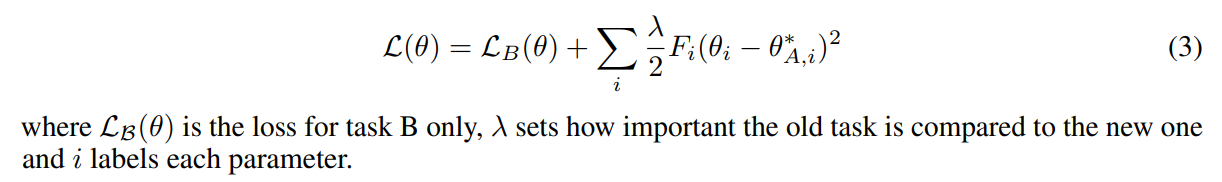


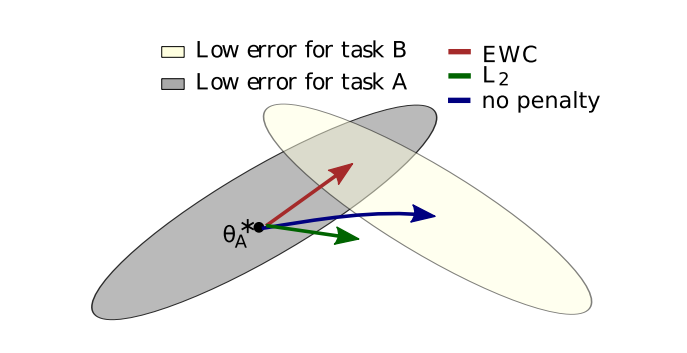

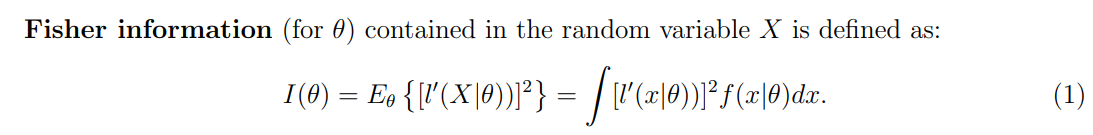

In [ ]:
from copy import deepcopy
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def variable(t, use_cuda=True, **kwargs):
    if isinstance(t, torch.Tensor):
        if torch.cuda.is_available() and use_cuda:
            t = t.cuda()
        return Variable(t, **kwargs)
    else:
        return t

In [ ]:
class LabelSmoother:
    """
    Adds label-smoothing on a pre-computed output from a Transformers model.

    Args:
        epsilon (`float`, *optional*, defaults to 0.1):
            The label smoothing factor.
        ignore_index (`int`, *optional*, defaults to -100):
            The index in the labels to ignore when computing the loss.
    """

    epsilon: float = 0.1
    ignore_index: int = -100

    def __call__(self, model_output, labels, shift_labels=False):
        logits = model_output["logits"] if isinstance(model_output, dict) else model_output[0]
        if shift_labels:
            logits = logits[..., :-1, :].contiguous()
            labels = labels[..., 1:].contiguous()

        log_probs = -nn.functional.log_softmax(logits, dim=-1)
        if labels.dim() == log_probs.dim() - 1:
            labels = labels.unsqueeze(-1)

        padding_mask = labels.eq(self.ignore_index)
        # In case the ignore_index is -100, the gather will fail, so we replace labels by 0. The padding_mask
        # will ignore them in any case.
        labels = torch.clamp(labels, min=0)
        labels = labels.type(torch.int64)
        nll_loss = log_probs.gather(dim=-1, index=labels)
        # works for fp16 input tensor too, by internally upcasting it to fp32
        smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)

        nll_loss.masked_fill_(padding_mask, 0.0)
        smoothed_loss.masked_fill_(padding_mask, 0.0)

        # Take the mean over the label dimensions, then divide by the number of active elements (i.e. not-padded):
        num_active_elements = padding_mask.numel() - padding_mask.long().sum()
        nll_loss = nll_loss.sum() / num_active_elements
        smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
        return (1 - self.epsilon) * nll_loss + self.epsilon * smoothed_loss
crit = LabelSmoother()

In [ ]:
class EWC(object):
    def __init__(self, model: nn.Module, dataset):

        self.model = model
        self.dataset = CustomDataset(dataset)

        # named_parameters :  (name, parameter)
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        # print(self.params)
        self._means = {}
        self._precision_matrices = self._diag_fisher()

      # 1) Parameters after learning Task A
        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
      # 2) Initialize precision matrices 0
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

			# 3) Accumulate gradients to calculate fisher
        self.model.eval()
        for inputs in self.dataset:
            self.model.zero_grad()
            with torch.enable_grad():
              input = torch.tensor(inputs['eval_ids']).to("cuda").to(torch.int64)
              output = torch.tensor(model(input.view(1,-1))[0],requires_grad=True).to(torch.float32)
              label = torch.tensor(inputs['input_ids']).to("cuda").to(torch.float32)
              loss = crit(output,label)
              #print(loss)
              if loss == 0:
                  continue
              else:
                  loss.backward(retain_graph=True)
                  for n, p in self.model.named_parameters():
                      if p.requires_grad:
                        precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

     #4) diag_fisher
      # diag_fisher is an indicator that shows how important the current parameter is to Task A.
      # To calculate diag_fisher, sample data from Task A and calculate the empirical Fisher information matrix
      # Correlation of parameters with previous learning data (Use Fisher information matrix when calculating F/
         # The amount of information that can be inferred about the parameters of the distribution from the observed value of a random variable)
      # Accumulate the squares of the gradients
      # (parameter ** 2)/len(dataset)
        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    # 5) penalty
    # Create a penalty term through diag* (the square of the difference between _means, the parameter after learning Task A, and the current parameter) of diag_fisher

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            if (p.requires_grad):
              _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
              loss += _loss.sum()
        return loss

In [ ]:
new_model.enable_input_require_grads()

In [ ]:
EWC_global = EWC(new_model, train_dataset_en)

# Custom EWC Trainer

In [ ]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
from copy import deepcopy
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

# Your EWC class remains the same

class EWCTrainer(Trainer):
    def __init__(self, ewc_lambda, model, train_dataset, eval_dataset, tokenizer, data_collator, args):
        super().__init__(model=model, train_dataset=train_dataset, eval_dataset=eval_dataset, tokenizer=tokenizer, data_collator=data_collator, args=args)
        self.ewc_lambda = ewc_lambda
        self.ewc = EWC_global

    def compute_loss(self, model, inputs, return_outputs=False):
        # crit=LabelSmoother(shift_labels=True)
        # config.inference_mode = False
        with torch.enable_grad():
          input = torch.tensor(inputs['eval_ids']).to("cuda").to(torch.int64)
          output = torch.tensor(model(input.view(1,-1))[0],requires_grad=True).to(torch.float32)
          label = torch.tensor(inputs['input_ids']).view(-1,1).to("cuda").to(torch.float32)
          loss = crit(output,label)
          print(loss)
          ewc_loss = self.ewc.penalty(model)
          print(ewc_loss)
          new_loss = loss + self.ewc_lambda * ewc_loss
        return (new_loss, output) if return_outputs else new_loss

# Finetune model by LoRA, EWC Trainer with Vietnamese Dataset

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

# Instantiate the custom trainer with EWC
ewc_lambda = 0.1  # Adjust this regularization strength
ewc_trainer = EWCTrainer(
    ewc_lambda,
    model=model,
    train_dataset=train_dataset,
    eval_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    args=TrainingArguments(
        output_dir="./results",
        remove_unused_columns=False,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=20,
        learning_rate=2.5e-5,
        logging_steps=5,
        fp16=True,
        optim="paged_adamw_8bit",
        save_strategy="steps",
        save_steps=50,
        evaluation_strategy="steps",
        eval_steps=5,
        do_eval=True,
        label_names=["input_ids", "labels", "attention_mask"],
        report_to="none",
    ),
)
ewc_trainer.train()

<ipython-input-53-ae47270d3c12>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(inputs['eval_ids']).to("cuda").to(torch.int64)
<ipython-input-53-ae47270d3c12>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(model(input.view(1,-1))[0],requires_grad=True).to(torch.float32)
<ipython-input-53-ae47270d3c12>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(inputs['input_ids']).view(-1,1).to("cuda").to(torch.float32)


tensor(8.5841, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.8958, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.2832, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.2957, device='cuda:0', grad_fn=<AddBackward0>)


AssertionError: No inf checks were recorded for this optimizer.

# Conclusion

Những bài học trong quá trình làm đồ án:
- Kiến thức về Continual Learning, kỹ thuật EWC
- LoRA, LoRA quantization, sử dụng LoRA để finetune model
- Sử dụng pretrained LLM.
- Template prompt ảnh hưởng đến kết quả model.
- Khoảng cách từ lý thuyết đến thực hành: có nhiều bug phát sinh trong quá trình hiện thực hóa ý tưởng.
- Custom class Trainer của Transformer.

# References

- Overcoming catastrophic forgetting in neural networks (https://arxiv.org/pdf/1612.00796.pdf
- Lecture 8: Elastic weight consolidation and language models (https://web.stanford.edu/class/msande338/lec8.pdf)
- LoRA: Low-Rank Adaptation of Large Language Models (https://arxiv.org/abs/2106.09685)
- Continual Learning EWC (https://sjkim-icd.github.io/continual-learning/EWC/)
- Continual Pre-training of Language Models (https://arxiv.org/abs/2302.03241)
- Fisher Information and Cramer-Rao Bound (https://people.missouristate.edu/songfengzheng/Teaching/MTH541/Lecture%20notes/Fisher_info.pdf)
